# Machine learning the alchemical potential for single elements
The alchemical potential distribution is very narrow (similar to distribution of atomisation energy of the full molecules, see analysis_atomic_properties.ipynb). Wide range of labels can be excluded as limiting factor $\rightarrow$ investigation of learning of $\mu_I$ can improve understanding of limiting factors.

## In this notebook
- learning curve of alchemical potential of only hydrogen
- learning curve of alchemical potential of all elements together

In [9]:
from matplotlib import pyplot as plt
plt.rcParams['font.size'] = 20
from matplotlib import cm as cmx
import matplotlib.colors as colors
import numpy as np
import pickle
import glob
from scipy import stats

def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [10]:
all_alchpots = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_all_alchpots.txt')
all_alchpots_b2 = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_all_alchpots_b2.txt')
all_alchpots_shifted = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_all_alchpots_shifted.txt')

alchpots_H = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_H.txt')
alchpots_H_b2 = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_H_b2.txt')

alchpots_C = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_C.txt')
alchpots_N = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_N.txt')
alchpots_O = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_O.txt')

In [11]:
datasets = [all_alchpots,all_alchpots_b2, 
            #all_alchpots_shifted, 
            alchpots_H, alchpots_H_b2, alchpots_C, alchpots_N, alchpots_O]
labels = [r'all $\mu$', r'all $\mu$ batch 2',
          #r'all $\mu$ shifted', 
          r'$\mu_{\rm{H}}$', r'$\mu_{\rm{H}}$ batch 2', r'$\mu_{\rm{C}}$', r'$\mu_{\rm{N}}$', r'$\mu_{\rm{O}}$']

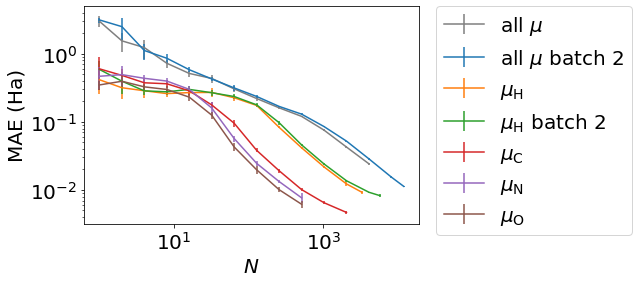

In [12]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1,1)
# plt.rcParams.update({'errorbar.capsize': 0})

for d,l in zip(datasets, labels):
    if l == r'all $\mu$':
        ax.errorbar(d[:,0], d[:,1], d[:,2], label=l, color = "tab:grey")
    else:
        ax.errorbar(d[:,0], d[:,1], d[:,2], label=l)

ax.set_xlabel(r'$N$')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

directory = ('/home/misa/projects/Atomic-Energies/figures/machine_learning/learning_curves/')
# plt.savefig(directory+'alchpots_split_up.png', bbox_inches='tight')

#### together with learning curve of molecular atomisation energies

In [ ]:
lcurve_ref = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/reference/l_curve_global_global.tab')
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1,1)
# plt.rcParams.update({'errorbar.capsize': 0})

for d,l in zip(datasets, labels):
    if l == r'all $\mu$':
        ax.errorbar(d[:,0], d[:,1], d[:,2], label=l, color = "tab:grey")
    else:
        ax.errorbar(d[:,0], d[:,1], d[:,2], label=l)

ax.errorbar(lcurve_ref[:,0], lcurve_ref[:,1], lcurve_ref[:,2], label = r'$E^{\rm{at, mol}}$')

ax.set_xlabel(r'$N$')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

directory = ('/home/misa/projects/Atomic-Energies/figures/machine_learning/learning_curves/')
plt.savefig(directory+'alchpots_split_up_with_ref.png', bbox_inches='tight')

#### slopes of the learning curves

In [ ]:
fit_ref=stats.linregress(np.log(lcurve_ref[:,0]), np.log(lcurve_ref[:,1]))
fit_all=stats.linregress(np.log(all_alchpots[:,0]), np.log(all_alchpots[:,1]))

In [ ]:
np.log(all_alchpots[:,0])

In [ ]:
def evaluate_fit(x,fit):
    return(fit[0]*x+fit[1])

evaluate_fit(np.log(all_alchpots[:,0]), fit_all)

In [ ]:
# plt.plot(np.log(lcurve_ref[:,0]),fit[0]*np.log(lcurve_ref[:,0])+fit[1])
# plt.plot(np.log(lcurve_ref[:,0]), np.log(lcurve_ref[:,1]))
labels = [r'all $\mu$', 
          #r'all $\mu$ shifted', 
          r'$\mu_{\rm{H}}$', r'$\mu_{\rm{C}}$', r'$\mu_{\rm{N}}$', r'$\mu_{\rm{O}}$',r'$E^{\rm{at, mol}}$',r'all $\mu$ last']

for i,l in zip([all_alchpots, alchpots_H[7:], alchpots_C[4:], alchpots_N[4:], alchpots_O[4:], lcurve_ref, all_alchpots[9:]],labels):
    x = np.log(i[:,0])
    y = np.log(i[:,1])
    fit = stats.linregress(x,y)
    y_fitted = evaluate_fit(x, fit)
    
#     plt.plot(x,y)
    if l == r'all $\mu$':
        plt.plot(x, y_fitted, label = l, color = 'tab:grey')
    else:
        plt.plot(x, y_fitted, label = l)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Load dictionaries

In [ ]:
all_sigma_all_lam_alchpots_{el_symbol}.txt

In [ ]:
all_alchpot_dict = load_obj('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/cm/all_sigma_all_lam_alchpots_H.txt')
lcurves = all_alchpot_dict
# alchpot_H_dict = load_obj('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/all_sigma_alchpots_O.txt')

In [ ]:
# lcurves

### Plotted results

In [ ]:
NUM_COLORS = 4#len(lcurves.keys())
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = [10.0, 10.0]
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for k in lcurves.keys():
    if k.startswith('sig_103.96830673359823_'):
        # r'$\sigma = {}$'.format(np.round( float(k.split('_')[1]), 2 ))
        ax.plot(lcurves[k][:,0], lcurves[k][:,1], '-o', label=k )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(lcurves['sig_222.8609442038079'][:,0],lcurves['sig_222.8609442038079'][:,1], '-o', label=r'$\sigma = 222$')
ax.plot(lcurves['sig_103.96830673359823'][:,0],lcurves['sig_103.96830673359823'][:,1], '-o', label=r'$\sigma = 104$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Minimum error for training set size of 2048 atoms = 0.012 Ha = 8 kcal/mol

Error in atomisation energy for QM7 molecules with 5000 training points = 5 kcal/mol and 8.5 kcal/mol for 2048 training points (and 5000 test points)

The errors are similar (check distribution of QM7 molecules to make sure they are also comparable)
suggests, that noise in data is not an issue but spread (shift and rescale)

compare to learning curve of 38Ve molecules

### Learning curves for alchemical potential

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

In [ ]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.concatenate((np.logspace(0, 13, 14, base=2).astype(int), np.array([12000])))

for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(all_local_reps, alch_pots, tr_size, sigma, lam_val, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]
path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_all_alchpots_b2.txt'
sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

In [ ]:
save_data

In [ ]:
# save dictionary of learning curves at all sigmas
fname = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/all_sigma_all_alchpots_b2.txt'
save_obj(lcurves, fname)

### Learning curves for alchemical potential shifted

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

# shift alchemical potentials by mean value per element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)
mean_alch_pots = qmi.get_average_property(np.arange(molecule_size.sum()), data, molecule_size, 'alch_pot')

delta_values = np.zeros((len(alch_pots)))
for k in idc_by_charge.keys():
    delta_values[idc_by_charge[k]] = mean_alch_pots[k]
labels_shifted = (alch_pots - delta_values).copy()

In [ ]:
# check that shift succesful


In [ ]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 10

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 11, 12, base=2).astype(int)

for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate(all_local_reps, labels_shifted, tr_size, sigma, lam_val, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]

# filename
path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_all_alchpots_shifted.txt'

sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

# save dictionary of learning curves at all sigmas
fname = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/all_sigma_all_alchpots_shifted.txt'
save_obj(lcurves, fname)

### Learning curves for alchemical potential of single elements

In [1]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def get_tr_size(data_size):
    """
    largest number of training points is roughly 90% of complete data (largest multiple of 2 that is <= 90%)
    """
    largest_set = int(np.log2(data_size*0.9))
    tr_size = np.logspace(0, largest_set, largest_set+1, base=2).astype(int)
    return(tr_size)

def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    elif int(Z) == 9:
        return('F')
    else:
        raise ValueError('Symbol for given charge not available')

In [2]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

In [3]:
# split up alchemical potential by element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

el_reps =dict()
el_alch_pots = dict()
for k in idc_by_charge.keys():
    el_reps[k] = all_local_reps[idc_by_charge[k]]
    el_alch_pots[k] = alch_pots[idc_by_charge[k]]

In [4]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 10

for charge in el_reps.keys():
    lcurves = dict()

    # define number of training points for which MAE is calculated
    set_sizes = np.concatenate((get_tr_size(len(el_alch_pots[charge])), np.array([int(len(el_alch_pots[charge])*0.9)])) )
    print(set_sizes)
    
    # special for H
#     set_sizes = np.concatenate((set_sizes, np.array([3300])))

    for sigma in sigmas:
        error_cv = []
        error_std = []
        # calculate error for every training point size
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate(el_reps[charge], el_alch_pots[charge], tr_size, sigma, lam_val, num_cv)
            error_cv.append(err)
            error_std.append(err_std)

        lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T
        
    
    # save best learning curve
    lowest_error = (None, None)
    for k in lcurves.keys():
        if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
            lowest_error = (k, np.amin(lcurves[k][:,1]))
    save_data = lcurves[lowest_error[0]]

    # filename
    el_symbol = get_element_symbol(charge)
    path = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_{el_symbol}_b2.txt'

    sig_val = lowest_error[0].split('_')[1]
    header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
    np.savetxt(path, save_data, delimiter='\t', header=header)

    # save dictionary of learning curves at all sigmas
    fname = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/all_sigma_alchpots_{el_symbol}_b2.txt'
    save_obj(lcurves, fname)

[   1    2    4    8   16   32   64  128  256  512 1024 2048 4096 5724]
[   1    2    4    8   16   32   64  128  256  512 1024 2048 4096 4149]
[   1    2    4    8   16   32   64  128  256  512 1024 1060]
[  1   2   4   8  16  32  64 128 256 512 870]
[1 2 2]


ValueError: Symbol for given charge not available

- the error is higher than for atomic energies (check for bugs, overwritten variables...)

$\rightarrow$ rescaling and shifting is probably not the issue

the surface is non smooth, rescaling does not help makes it even more non smooth

$\rightarrow$ change of representation could help

- also learning only H is easier (maybe smoother)
$\rightarrow$ learn all elements individually

what is the optimal representation? 
$\rightarrow$  investigate label distribution, distance distribution (for all together/single element)

deep neural networks are supposed to work better for non smooth systems

### Learning curves for alchemical potential of single elements optimize $\sigma$ and $\lambda$

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

def crossvalidate(reps, labels, tr_size, sigma, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=tr_size)
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def get_tr_size(data_size):
    """
    largest number of training points is roughly 90% of complete data (largest multiple of 2 that is <= 90%)
    """
    largest_set = int(np.log2(data_size*0.9))
    tr_size = np.logspace(0, largest_set, largest_set+1, base=2).astype(int)
    return(tr_size)

def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    else:
        raise ValueError('Symbol for given charge not available')

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

all_local_reps = qmi.generate_atomic_representations(data, molecule_size)

In [ ]:
# split up alchemical potential by element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

el_reps =dict()
el_alch_pots = dict()
for k in idc_by_charge.keys():
    el_reps[k] = all_local_reps[idc_by_charge[k]]
    el_alch_pots[k] = alch_pots[idc_by_charge[k]]

In [ ]:
# best sigmas
sigmas = np.logspace(-1, 10, 11, base=2)[6:11]
lam_vals = [1e-3, 1e-5, 1e-7, 1e-9]
num_cv = 10

for charge in el_reps.keys():
    lcurves = dict()

    # define number of training points for which MAE is calculated
    set_sizes = get_tr_size(len(el_alch_pots[charge]))
    
    # special for H
#     set_sizes = np.concatenate((set_sizes, np.array([3300])))

    for sigma in sigmas:
        for lam_val in lam_vals:
            error_cv = []
            error_std = []
            # calculate error for every training point size
            for idx, tr_size in enumerate(set_sizes):
                err, err_std = crossvalidate(el_reps[charge], el_alch_pots[charge], tr_size, sigma, lam_val, num_cv)
                error_cv.append(err)
                error_std.append(err_std)

            lcurves[f'sig_{sigma}_lam{lam_val}'] = np.array([set_sizes, error_cv, error_std]).T
        
    
#     # save best learning curve
#     lowest_error = (None, None)
#     for k in lcurves.keys():
#         if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
#             lowest_error = (k, np.amin(lcurves[k][:,1]))
#     save_data = lcurves[lowest_error[0]]

    # filename
    el_symbol = get_element_symbol(charge)
#     path = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/best_alchpots_{el_symbol}.txt'

#     sig_val = lowest_error[0].split('_')[1]
#     header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
#     np.savetxt(path, save_data, delimiter='\t', header=header)

    # save dictionary of learning curves at all sigmas
    fname = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/cm/all_sigma_all_lam_alchpots_{el_symbol}.txt'
    save_obj(lcurves, fname)

In [ ]:
lcurves